In [1]:
import os
import warnings

os.environ['TF_USE_LEGACY_KERAS'] = '1'
warnings.filterwarnings("ignore")

if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    print('Running in Kaggle')
    IN_KAGGLE = True
    IN_COLAB = False
    DATA_DIR = "/kaggle/input/DATASET"

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
elif 'COLAB_GPU' in os.environ:
    print('Running in Google Colab')
    IN_KAGGLE = False
    IN_COLAB = True
    DATA_DIR = "/content/drive/MyDrive/DATASET"

    from google.colab import drive
    drive.mount('/content/drive')
else:
    print('Running Local')
    IN_KAGGLE = False
    IN_COLAB = False
    DATA_DIR = "./data/"

if IN_KAGGLE or IN_COLAB:
    %pip install scikit-learn
    %pip install statsmodels
    %pip install matplotlib
    %pip install yfinance
    %pip install pyarrow
    %pip install ta
    %pip install tqdm

    # TensorFlow and TF-Agents version compatibility
    %pip install tensorflow==2.15.1
    %pip install tf-agents==0.19.0
    %pip install dm-reverb==0.14.0

print(f"Current Working Directory: {os.getcwd()}")

Running in Kaggle
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 27.5 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 5.3 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.6-cp310-cp310-linux_x86_64.whl size=275728 sha256=321c3e97d67f68eaa9250210287838e6e77afd35ec8fc61c571696bf0bcb4972
  Stored in directory: /root/.cache/pip/wheels/4b/b9/b0/83d6e258e8f963f5ff111a2cd8c483ca59372a86e6a2535212
Successfully built peewee
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py)

In [2]:
import math
import shutil
import tempfile
import numpy as np
import yfinance as yf
import pandas as pd
from datetime import datetime
from tqdm import tqdm

from scipy.stats import skew, kurtosis
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS

import matplotlib.pyplot as plt

from ta.trend import MACD, EMAIndicator
from ta.volatility import AverageTrueRange

import tensorflow as tf
from tf_agents.train import learner
from tf_agents.specs import array_spec, tensor_spec
from tf_agents.trajectories import time_step as ts
from tf_agents.utils import common
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import py_environment, tf_py_environment, utils
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy, policy_saver, random_tf_policy
from tf_agents.train.utils import strategy_utils

import reverb
from tf_agents.replay_buffers import reverb_replay_buffer, reverb_utils

2024-10-08 21:32:43.714379: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 21:32:43.714473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 21:32:43.716050: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def initialize_strategy():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        # Enable memory growth for each detected GPU
        for gpu in gpus:
            tf.config.set_logical_device_configuration(
                gpu, [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])  # Adjust memory limit if needed
        strategy = tf.distribute.MirroredStrategy()
        print(f"GPU devices found: {gpus}")
    else:
        # Default to a single-device strategy (CPU) if no GPUs are available
        strategy = tf.distribute.get_strategy()
        print("No GPU found. Using CPU strategy.")
    return strategy

strategy = initialize_strategy()

GPU devices found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Parameters and Constants

In [4]:
# Paths
MODELS_PATH = './models'
LOGS_PATH = './logs'
AGENT_HISTORY = f"{LOGS_PATH}/history"
DATA_DIR = "./data"
os.makedirs(MODELS_PATH, exist_ok=True)
os.makedirs(LOGS_PATH, exist_ok=True)
os.makedirs(AGENT_HISTORY, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

# Indices and tickers
START_DATE = "2017-01-01"   # Training dates
SPLIT_DATE = '2018-01-01'   # Testing cutoff
END_DATE = "2019-12-31"     # Testing dates
INDEX = "Date"
TARGET = 'TSLA'
RATES_INDEX = "^FVX"        # 5 Year Treasury Note Yield
VOLATILITY_INDEX = "^VIX"   # CBOE Volatility Index
SMALLCAP_INDEX = "^RUT"     # Russell 2000 Index
GOLD_FUTURES = "GC=F"       # Gold futures
OIL_FUTURES = "CL=F"        # Crude Oil Futures
MARKET = "^SPX"             # S&P 500 Index
TICKER_SYMBOLS = [TARGET, RATES_INDEX, VOLATILITY_INDEX, SMALLCAP_INDEX, GOLD_FUTURES, MARKET, OIL_FUTURES]
INTERVAL = "1d"
TRADING_DAYS_YEAR = 252     # Trading days in a year
RISK_FREE_RATE = 0.021      # Average riskfree from 2012 to 2020

# Trading Params
ACT_SHORT = 0
ACT_LONG = 1
ACT_HOLD = 2
ACTIONS = [ACT_SHORT, ACT_LONG]
CAPITAL = 100000
TRADE_COSTS_PERCENT = 10 / 100 / 100  # 10 basis points costs

# Hyperparameters
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
LEARN_RATE = 1e-3           # The networks learning rate (min 1e-5)
TRAIN_EPISODES = 500        # Number of episodes to train the networks (max 1000)
COLLECT_SIZE = 1000         # Default memory buffer, should default to observation state size
STATE_LEN = 30              # How much historic timesteps to return from the environment
LOG_INTERVALS = 20          # Log every X iterations
TEST_INTERVALS = 100        # Every X iterations, validate
TARGET_UPDATE_ITERS = 20    # Update the target networks
VALIDATION_ITERS = 10       # Repeat the experiment N times for significant metrics
DISCOUNT = 0.4              # The gamma in the bellman, how much to discount past rewards
EPSILON_START = 1.0         # For epsilon greedy algos, how much to explore VS exploit
EPSILON_END = 0.01          # At the end there should be more exploitation
EPSILON_DECAY = 10000       # Used for anealing the epsilon
GRAD_CLIP = 1.0             # Stop exploding/disappearing gradients
REWARD_CLIP = 1.0           # Stop exploding/disappearing rewards
DROPOUT = 0.2               # Chance of tensor dropout
L2FACTOR = 1e-5             # Regularization wieghts
ADAM_WEIGHTS = 1e-5         # Weighted Optimizer
NEURONS = 512               # Network capacity
LAYERS = (NEURONS, NEURONS, NEURONS, NEURONS, NEURONS)

# Financial data

We download some financial data, this is now the standard in our articles.

In [5]:
def get_tickerdata(tickers_symbols, start=START_DATE, end=END_DATE, interval=INTERVAL, data_dir=DATA_DIR):
    tickers = {}
    earliest_end= datetime.strptime(end,'%Y-%m-%d')
    latest_start = datetime.strptime(start,'%Y-%m-%d')
    os.makedirs(DATA_DIR, exist_ok=True)
    for symbol in tickers_symbols:
        cached_file_path = f"{data_dir}/{symbol}-{start}-{end}-{interval}.csv"

        try:
            if os.path.exists(cached_file_path):
                df = pd.read_parquet(cached_file_path)
                df.index = pd.to_datetime(df.index)
                assert len(df) > 0
            else:
                df = yf.download(
                    symbol,
                    start=START_DATE,
                    end=END_DATE,
                    progress=False,
                    interval=INTERVAL,
                )
                assert len(df) > 0
                df.to_parquet(cached_file_path, index=True, compression="snappy")
            min_date = df.index.min()
            max_date = df.index.max()
            nan_count = df["Close"].isnull().sum()
            skewness = round(skew(df["Close"].dropna()), 2)
            kurt = round(kurtosis(df["Close"].dropna()), 2)
            outliers_count = (df["Close"] > df["Close"].mean() + (3 * df["Close"].std())).sum()
            print(
                f"{symbol} => min_date: {min_date}, max_date: {max_date}, kurt:{kurt}, skewness:{skewness}, outliers_count:{outliers_count},  nan_count: {nan_count}"
            )
            tickers[symbol] = df

            if min_date > latest_start:
                latest_start = min_date
            if max_date < earliest_end:
                earliest_end = max_date
        except Exception as e:
            print(f"Error with {symbol}: {e}")

    return tickers, latest_start, earliest_end

tickers, latest_start, earliest_end = get_tickerdata(TICKER_SYMBOLS)
stock_df = tickers[TARGET].copy()

TSLA => min_date: 2017-01-03 00:00:00, max_date: 2019-12-30 00:00:00, kurt:-0.56, skewness:-0.28, outliers_count:0,  nan_count: 0
^FVX => min_date: 2017-01-03 00:00:00, max_date: 2019-12-30 00:00:00, kurt:-1.28, skewness:0.19, outliers_count:0,  nan_count: 0
^VIX => min_date: 2017-01-03 00:00:00, max_date: 2019-12-30 00:00:00, kurt:3.5, skewness:1.55, outliers_count:11,  nan_count: 0
^RUT => min_date: 2017-01-03 00:00:00, max_date: 2019-12-30 00:00:00, kurt:-0.71, skewness:0.05, outliers_count:0,  nan_count: 0
GC=F => min_date: 2017-01-03 00:00:00, max_date: 2019-12-30 00:00:00, kurt:0.24, skewness:1.05, outliers_count:0,  nan_count: 0
^SPX => min_date: 2017-01-03 00:00:00, max_date: 2019-12-30 00:00:00, kurt:-0.78, skewness:-0.05, outliers_count:0,  nan_count: 0
CL=F => min_date: 2017-01-03 00:00:00, max_date: 2019-12-30 00:00:00, kurt:-0.78, skewness:0.31, outliers_count:0,  nan_count: 0


## Feature Engineering

In [6]:
MACRO_FEATURES = [RATES_INDEX, VOLATILITY_INDEX, MARKET, GOLD_FUTURES, OIL_FUTURES]
TA_FEATURES = ['MACD', 'MACD_HIST', 'MACD_SIG', 'ATR', 'EMA_SHORT', 'EMA_MID', 'EMA_LONG']
HLOC_FEATURES = ["Close", "High", "Low", "Open", "Volume"]
FEATURES = ['Price Returns', 'Price Delta', 'Close Position', 'Volume']
TARGET_FEATURE = "Price Raw"

## Technicals

These are technical analysis features to be leveraged by our networks.

In [7]:

macd = MACD(close=stock_df["Close"], window_slow=26, window_fast=12, window_sign=9, fillna=True)
stock_df['MACD'] = macd.macd()
stock_df['MACD_HIST'] = macd.macd_diff()
stock_df['MACD_SIG'] = macd.macd_signal()

atr = AverageTrueRange(stock_df["High"], stock_df["Low"], stock_df["Close"], window = 14, fillna = True)
stock_df['ATR'] = atr.average_true_range()

ema = EMAIndicator(stock_df["Close"], window = 12, fillna = True)
stock_df['EMA_SHORT'] = ema.ema_indicator()
ema = EMAIndicator(stock_df["Close"], window = 26, fillna = True)
stock_df['EMA_MID'] = ema.ema_indicator()
ema = EMAIndicator(stock_df["Close"], window = 200, fillna = True)
stock_df['EMA_LONG'] = ema.ema_indicator()

stock_df.tail(5)

,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_HIST,MACD_SIG,ATR,EMA_SHORT,EMA_MID,EMA_LONG
Date,,,,,,,,,,,,,
2019-12-23,27.452000,28.134001,27.333332,27.948000,27.948000,199794000,1.430910,0.395042,1.035868,0.775349,25.373528,23.942618,19.043219
2019-12-24,27.890667,28.364668,27.512667,28.350000,28.350000,120820500,1.562356,0.421191,1.141165,0.780824,25.831447,24.269091,19.135824
2019-12-26,28.527332,28.898666,28.423332,28.729334,28.729334,159508500,1.677797,0.429305,1.248492,0.764242,26.277276,24.599479,19.231282
2019-12-27,29.000000,29.020666,28.407333,28.691999,28.691999,149185500,1.746143,0.398121,1.348022,0.753462,26.648772,24.902629,19.325418
2019-12-30,28.586000,28.600000,27.284000,27.646667,27.646667,188796000,1.696403,0.278705,1.417698,0.800215,26.802294,25.105891,19.408217


## Macro

These are macro features, whose change will be observed by our networks.

In [8]:
stock_df[VOLATILITY_INDEX] = tickers[VOLATILITY_INDEX]["Close"].pct_change().fillna(0)
stock_df[RATES_INDEX] = tickers[RATES_INDEX]["Close"].pct_change().fillna(0)
stock_df[SMALLCAP_INDEX] = tickers[SMALLCAP_INDEX]["Close"].pct_change().fillna(0)
stock_df[GOLD_FUTURES] = tickers[GOLD_FUTURES]["Close"].pct_change().fillna(0)
stock_df[OIL_FUTURES] = tickers[OIL_FUTURES]["Close"].pct_change().fillna(0)
stock_df[MARKET] = tickers[MARKET]["Close"].pct_change().fillna(0)

stock_df.tail(5)

,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_HIST,MACD_SIG,ATR,EMA_SHORT,EMA_MID,EMA_LONG,^VIX,^FVX,^RUT,GC=F,CL=F,^SPX
Date,,,,,,,,,,,,,,,,,,,
2019-12-23,27.452000,28.134001,27.333332,27.948000,27.948000,199794000,1.430910,0.395042,1.035868,0.775349,25.373528,23.942618,19.043219,0.007994,0.014459,0.001340,0.005289,0.001324,0.000866
2019-12-24,27.890667,28.364668,27.512667,28.350000,28.350000,120820500,1.562356,0.421191,1.141165,0.780824,25.831447,24.269091,19.135824,0.004758,-0.017104,0.002312,0.011197,0.009749,-0.000195
2019-12-26,28.527332,28.898666,28.423332,28.729334,28.729334,159508500,1.677797,0.429305,1.248492,0.764242,26.277276,24.599479,19.231282,-0.001579,0.000580,-0.000203,0.006804,0.009327,0.005128
2019-12-27,29.000000,29.020666,28.407333,28.691999,28.691999,149185500,1.746143,0.398121,1.348022,0.753462,26.648772,24.902629,19.325418,0.061660,-0.027246,-0.005150,0.002982,0.000649,0.000034
2019-12-30,28.586000,28.600000,27.284000,27.646667,27.646667,188796000,1.696403,0.278705,1.417698,0.800215,26.802294,25.105891,19.408217,0.103500,0.001788,-0.002924,0.000462,-0.000648,-0.005781


# Trading Environment

Using TensorFlow's PyEnvironment, we will give the agent the environment that implements the above rules:

In [9]:
class TradingEnv(py_environment.PyEnvironment):
    """
    A custom trading environment for reinforcement learning, compatible with tf_agents.

    This environment simulates a simple trading scenario where an agent can take one of three actions:
    - Long (buy), Short (sell), or Hold a financial instrument, aiming to maximize profit through trading decisions.

    Parameters:
    - data: DataFrame containing the stock market data.
    - data_dim: Dimension of the data to be used for each observation.
    - money: Initial capital to start trading.
    - state_length: Number of past observations to consider for the state.
    - transaction_cost: Costs associated with trading actions.
    """

    def __init__(self, data, features = FEATURES + MACRO_FEATURES, money=CAPITAL, state_length=STATE_LEN, transaction_cost=0, market_costs=TRADE_COSTS_PERCENT, reward_discount=DISCOUNT):
        super(TradingEnv, self).__init__()

        assert data is not None

        self.features = features
        self.data_dim = len(self.features)
        self.state_length = state_length
        self.current_step = self.state_length
        self.reward_discount = reward_discount

        self.balance = money
        self.initial_balance = money
        self.transaction_cost = transaction_cost
        self.epsilon = max(market_costs, np.finfo(float).eps) # there is always volatility costs
        self.total_shares = 0

        self._episode_ended = False
        self._batch_size = 1
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=ACT_SHORT, maximum=ACT_LONG, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(self.state_length * self.data_dim, ), dtype=np.float32, name='observation')

        self.data = self.preprocess_data(data.copy())
        self.reset()

    @property
    def batched(self):
        return False #True

    @property
    def batch_size(self):
        return None #self._batch_size

    @batch_size.setter
    def batch_size(self, size):
        self._batch_size = size

    def preprocess_data(self, df):
        price_raw = df['Close'].copy()

        # Engineer features from HLOC
        df['Price Returns'] = df['Close'].pct_change().fillna(0)
        df['Price Delta'] = (df['High'] - df['Low'])
        df['Close Position'] = abs(df['Close'] - df['Low']) / df['Price Delta'].replace(0, 0.5)
        for col in [col for col in self.features]:
            col_min, col_max = df[col].min(), df[col].max()
            if col_min != col_max:
                df[col] = (df[col] - col_min) / (col_max - col_min)
            else:
                df[col] = 0.
        df = df.ffill().bfill()

        df[TARGET_FEATURE] = price_raw
        df['Sharpe'] = 0
        df['Position'] = 0
        df['Action'] = ACT_HOLD
        df['Holdings'] = 0.0
        df['Cash'] = float(self.balance)
        df['Money'] = df['Holdings'] + df['Cash']
        df['Reward'] = 0.0

        assert not df.isna().any().any()

        return df

    def action_spec(self):
        """Provides the specification of the action space."""
        return self._action_spec

    def observation_spec(self):
        """Provides the specification of the observation space."""
        return self._observation_spec

    def _reset(self):
        """Resets the environment state and prepares for a new episode."""
        self.balance = self.initial_balance
        self.current_step = self.state_length
        self._episode_ended = False
        self.total_shares = 0

        self.data['Reward'] = 0.
        self.data['Sharpe'] = 0.
        self.data['Position'] = 0
        self.data['Action'] = ACT_HOLD
        self.data['Holdings'] = 0.
        self.data['Cash']  = float(self.balance)
        self.data['Money'] = self.data.iloc[0]['Holdings'] + self.data.iloc[0]['Cash']
        self.data['Returns'] = 0.

        return ts.restart(self._next_observation())

    def _next_observation(self):
        """Generates the next observation based on the current step and history length."""
        start_idx = max(0, self.current_step - self.state_length + 1)
        end_idx = self.current_step + 1
        obs = self.data[self.features].iloc[start_idx:end_idx]

        # flatten because: https://stackoverflow.com/questions/67921084/dqn-agent-issue-with-custom-environment
        obs_values = obs.values.flatten().astype(np.float32)
        return obs_values

    def _step(self, action):
        """Executes a trading action and updates the environment's state."""
        if self._episode_ended:
            return self.reset()

        self.current_step += 1
        current_price = self.data.iloc[self.current_step][TARGET_FEATURE]

        assert not self.data.iloc[self.current_step].isna().any().any()

        if action == ACT_LONG:
            self._process_long_position(current_price)
        elif action == ACT_SHORT:
            prev_current_price = self.data.iloc[self.current_step - 1][TARGET_FEATURE]
            self._process_short_position(current_price, prev_current_price)
        elif action == ACT_HOLD:
            self._process_hold_position()
        else:
          raise Exception(f"Invalid Actions: {action}")

        self._update_financials()
        done = self.current_step >= len(self.data) - 1
        reward = self._calculate_sharpe_reward_signal()
        # reward = self.data['Returns'][self.current_step]
        self.data.at[self.data.index[self.current_step], "Reward"] = reward
        if done:
            self._episode_ended = True
            return ts.termination(self._next_observation(), reward)
        else:
            return ts.transition(self._next_observation(), reward, discount=self.reward_discount)

    def _get_lower_bound(self, cash, total_shares, price):
        """
        Compute the lower bound of the action space, particularly for short selling,
        based on current cash, the number of shares, and the current price.
        """
        delta = -cash - total_shares * price * (1 + self.epsilon) * (1 + self.transaction_cost)

        if delta < 0:
            lowerBound = delta / (price * (2 * self.transaction_cost + self.epsilon * (1 + self.transaction_cost)))
        else:
            lowerBound = delta / (price * self.epsilon * (1 + self.transaction_cost))

        if np.isinf(lowerBound):
            assert False
        return lowerBound

    def _process_hold_position(self):
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, "Cash"] = self.data.iloc[self.current_step - 1]["Cash"]
        self.data.at[step_idx, "Holdings"] = self.data.iloc[self.current_step - 1]["Holdings"]
        self.data.at[step_idx, "Position"] = self.data.iloc[self.current_step - 1]["Position"]
        self.data.at[step_idx, "Action"] = ACT_HOLD

    def _process_long_position(self, current_price):
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, 'Position'] = 1
        self.data.at[step_idx, 'Action'] = ACT_LONG

        if self.data.iloc[self.current_step - 1]['Position'] == 1:
            # more long
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]['Cash']
            self.data.at[step_idx, 'Holdings'] = self.total_shares * current_price
            self.data.at[step_idx, "Action"] = ACT_HOLD
        elif self.data.iloc[self.current_step - 1]['Position'] == 0:
            # new long
            self.total_shares = math.floor(self.data.iloc[self.current_step - 1]['Cash'] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = self.total_shares * current_price
        else:
            # short to long
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
            self.total_shares = math.floor(self.data.iloc[self.current_step]['Cash'] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step]['Cash'] - self.total_shares * current_price * (1 + self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = self.total_shares * current_price

    def _process_short_position(self, current_price, prev_price):
        """
        Adjusts the logic for processing short positions to include lower bound calculations.
        """
        step_idx = self.data.index[self.current_step]
        self.data.at[step_idx, 'Position'] = -1
        self.data.at[step_idx, "Action"] = ACT_SHORT
        if self.data.iloc[self.current_step - 1]['Position'] == -1:
            # Short more
            low = self._get_lower_bound(self.data.iloc[self.current_step - 1]['Cash'], -self.total_shares, prev_price)
            if low <= 0:
                self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"]
                self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price
                self.data.at[step_idx, "Action"] = ACT_HOLD
            else:
                total_sharesToBuy = min(math.floor(low), self.total_shares)
                self.total_shares -= total_sharesToBuy
                self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"] - total_sharesToBuy * current_price * (1 + self.transaction_cost)
                self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price
        elif self.data.iloc[self.current_step - 1]['Position'] == 0:
            # new short
            self.total_shares = math.floor(self.data.iloc[self.current_step - 1]["Cash"] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"] + self.total_shares * current_price * (1 - self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price
        else:
            # long to short
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step - 1]["Cash"] + self.total_shares * current_price * (1 - self.transaction_cost)
            self.total_shares = math.floor(self.data.iloc[self.current_step]["Cash"] / (current_price * (1 + self.transaction_cost)))
            self.data.at[step_idx, 'Cash'] = self.data.iloc[self.current_step]["Cash"] + self.total_shares * current_price * (1 - self.transaction_cost)
            self.data.at[step_idx, 'Holdings'] = -self.total_shares * current_price

    def _update_financials(self):
        """Updates the financial metrics including cash, money, and returns."""
        step_idx = self.data.index[self.current_step]
        self.balance = self.data.iloc[self.current_step]['Cash']

        self.data.at[step_idx,'Money'] = self.data.iloc[self.current_step]['Holdings'] + self.data.iloc[self.current_step]['Cash']
        self.data.at[step_idx,'Returns'] = ((self.data.iloc[self.current_step]['Money'] - self.data.iloc[self.current_step - 1]['Money'])) / self.data.iloc[self.current_step - 1]['Money']

    def _calculate_reward_signal(self, reward_clip=REWARD_CLIP):
        """
        Calculates the reward for the current step. In the paper they use the %returns.
        """
        reward = self.data.iloc[self.current_step]['Returns']
        return np.clip(reward, -reward_clip, reward_clip)

    def _calculate_sharpe_reward_signal(self, risk_free_rate=RISK_FREE_RATE, periods_per_year=TRADING_DAYS_YEAR, reward_clip=REWARD_CLIP):
        """
        Calculates the annualized Sharpe ratio up to the CURRENT STEP.

        Parameters:
        - risk_free_rate (float): The annual risk-free rate. It will be adjusted to match the period of the returns.
        - periods_per_year (int): Number of periods in a year (e.g., 252 for daily, 12 for monthly).

        Returns:
        - float: The annualized Sharpe ratio as reward.
        """
        observed_returns = self.data['Returns'].iloc[:self.current_step + 1]
        period_risk_free_rate = risk_free_rate / periods_per_year
        excess_returns = observed_returns - period_risk_free_rate

        rets = np.mean(excess_returns)
        std_rets = np.std(excess_returns)

        sr = rets / std_rets if std_rets > 0 else 0
        annual_sr = sr * np.sqrt(periods_per_year)

        self.data.at[self.data.index[self.current_step], 'Sharpe'] = annual_sr

        return np.clip(annual_sr, -reward_clip, reward_clip)

    def get_trade_data(self):
        self.data['cReturns'] = np.cumprod(1 + self.data['Returns']) - 1
        return self.data.iloc[:self.current_step + 1]


    def render(self, mode='human'):
        print(f'Step: {self.current_step}, Balance: {self.balance}, Holdings: {self.total_shares}')
        print(f"trade stats: {self.get_trade_stats()}")

In [10]:
train_data = stock_df[stock_df.index < pd.to_datetime(SPLIT_DATE)].copy()
test_data = stock_df[stock_df.index >= pd.to_datetime(SPLIT_DATE)].copy()

train_env = TradingEnv(train_data)
# utils.validate_py_environment(train_env, episodes=TRAIN_EPISODES // 5)
test_env = TradingEnv(test_data)
# utils.validate_py_environment(train_env, episodes=TRAIN_EPISODES // 5)

print(f"TimeStep Specs: {train_env.time_step_spec()}")
print(f"Action Specs: {train_env.action_spec()}")
print(f"Reward Specs: {train_env.time_step_spec().reward}")

TimeStep Specs: TimeStep(
{'step_type': ArraySpec(shape=(), dtype=dtype('int32'), name='step_type'),
 'reward': ArraySpec(shape=(), dtype=dtype('float32'), name='reward'),
 'discount': BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0),
 'observation': BoundedArraySpec(shape=(270,), dtype=dtype('float32'), name='observation', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38)})
Action Specs: BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=1)
Reward Specs: ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [11]:
def execute_action_and_print_state(env, action):
    next_time_step = env.step(np.array(action, dtype=np.int32))
    print(f'Action taken: {action} at step: {env.current_step}')
    # print(f'New state: {next_time_step.observation}')
    print(f'New balance: {env.balance}')
    print(f'Total shares: {env.total_shares}')
    print(f'Reward: {next_time_step.reward}\n')

time_step = train_env.reset()

# Some dryruns to validate our env logic: Buy, Sell, we should have a positive balance with TSLA
execute_action_and_print_state(train_env, ACT_HOLD)
execute_action_and_print_state(train_env, ACT_LONG)
execute_action_and_print_state(train_env, ACT_SHORT)
execute_action_and_print_state(train_env, ACT_HOLD)
execute_action_and_print_state(train_env, ACT_LONG)

Action taken: 2 at step: 31
New balance: 100000.0
Total shares: 0
Reward: 0.0

Action taken: 1 at step: 32
New balance: 0.848236083984375
Total shares: 5510
Reward: 0.0

Action taken: 0 at step: 33
New balance: 203790.03025054932
Total shares: 5510
Reward: 1.0

Action taken: 2 at step: 34
New balance: 203790.03025054932
Total shares: 5510
Reward: 1.0

Action taken: 1 at step: 35
New balance: 4.924432754516602
Total shares: 6431
Reward: 1.0



In [12]:
def create_q_network(env, fc_layer_params=LAYERS, dropout_rate=DROPOUT, l2_reg=L2FACTOR):
    """
    Creates a Q-Network with dropout and batch normalization.
    Parameters:
    - env: The environment instance.
    - fc_layer_params: Tuple of integers representing the number of units in each dense layer.
    - dropout_rate: Dropout rate for dropout layers.
    - l2_reg: L2 regularization factor.

    Returns:
    - q_net: The Q-Network model.
    """
    env = tf_py_environment.TFPyEnvironment(env)
    action_tensor_spec = tensor_spec.from_spec(env.action_spec())
    num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

    layers = []
    for num_units in fc_layer_params:
        layers.append(tf.keras.layers.Dense(
                                num_units,
                                activation=None,
                                kernel_initializer=tf.keras.initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='truncated_normal'),
                                kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
        # Internal Covariate Shift Reductio by normalizing layer inputs, this improves gradient flow.
        layers.append(tf.keras.layers.BatchNormalization())
        layers.append(tf.keras.layers.LeakyReLU())
        layers.append(tf.keras.layers.Dropout(dropout_rate))

    q_values_layer = tf.keras.layers.Dense(
        num_actions,
        activation=None,
        kernel_initializer=tf.keras.initializers.GlorotNormal(),
        bias_initializer=tf.keras.initializers.GlorotNormal(),
        kernel_regularizer=tf.keras.regularizers.l2(l2_reg))

    q_net = sequential.Sequential(layers + [q_values_layer])

    return q_net

def create_agent(q_net, env,
                 t_q_net=None,
                 optimizer=None,
                 eps=EPSILON_START,
                 learning_rate=LEARN_RATE,
                 gradient_clipping=GRAD_CLIP,
                 weight_decay = ADAM_WEIGHTS,
                 discount=DISCOUNT):
    """
    Creates a DDQN agent for a given environment with specified configurations.

    Parameters:
    - q_net (tf_agents.networks.Network): The primary Q-network for the agent.
    - env (tf_agents.environments.PyEnvironment or tf_agents.environments.TFPyEnvironment):
      The environment the agent will interact with. A TFPyEnvironment wrapper is applied
      if not already wrapped.
    - t_q_net (tf_agents.networks.Network, optional): The target Q-network for the agent.
      If None, no target network is used.
    - optimizer (tf.keras.optimizers.Optimizer, optional): The optimizer to use for training the agent.
      If None, an Adam optimizer with exponential decay learning rate is used.
    - eps (float): The epsilon value for epsilon-greedy exploration.
    - learning_rate (float): The initial learning rate for the exponential decay learning rate schedule.
      Ignored if an optimizer is provided.
    - gradient_clipping (float): The value for gradient clipping. If 1., no clipping is applied.

    Returns:
    - agent (tf_agents.agents.DqnAgent): The initialized and configured DDQN agent.
    """
    if optimizer is None:
      optimizer = tf.keras.optimizers.AdamW(
          learning_rate=learning_rate,
          weight_decay=weight_decay
      )
    env = tf_py_environment.TFPyEnvironment(env)
    agent = dqn_agent.DqnAgent(
        env.time_step_spec(),
        env.action_spec(),
        gamma=discount,
        q_network=q_net,
        target_q_network=t_q_net,
        target_update_period=TARGET_UPDATE_ITERS,
        optimizer=optimizer,
        epsilon_greedy=eps,
        reward_scale_factor=1,
        gradient_clipping=gradient_clipping,
        td_errors_loss_fn=common.element_wise_huber_loss,
        train_step_counter=tf.compat.v1.train.get_or_create_global_step(),
        name="Trader"
    )

    agent.initialize()
    print(agent.policy)
    print(agent.collect_policy)
    return agent

with strategy.scope():
  q_net = create_q_network(train_env)
  t_q_net = create_q_network(train_env)
  agent = create_agent(q_net, train_env, t_q_net=t_q_net)

In [13]:
class TradingSimulator:
    """
    A simulator class to train and evaluate a DDQN agent on a trading environment using TF-Agents and Reverb.

    Args:
        env: A Python environment for training the agent.
        eval_env: A Python environment for evaluating the agent.
        agent: The DDQN agent to be trained.
        episodes (int): Total number of episodes for training.
        batch_size (int): Size of the batches used in replay buffer.
        collect_steps (int): Number of steps to collect in each training step.
        log_interval (int): Frequency of logging during training.
        eval_interval (int): Frequency of evaluation during training.
        global_step (int): A global step tracker.
    """

    def __init__(self,
                 env,
                 eval_env,
                 agent,
                 episodes=TRAIN_EPISODES, batch_size=BATCH_SIZE,
                 collect_steps=COLLECT_SIZE,
                 log_interval=LOG_INTERVALS,
                 eval_interval=TEST_INTERVALS,
                 global_step=None):
        assert env is not None and eval_env is not None and agent is not None

        self.py_env = env
        self.env = tf_py_environment.TFPyEnvironment(self.py_env)
        self.py_eval_env = eval_env
        self.eval_env = tf_py_environment.TFPyEnvironment(self.py_eval_env)
        self.agent = agent
        self.episodes = episodes
        self.log_interval = log_interval
        self.eval_interval = eval_interval
        self.global_step = global_step if global_step is not None else tf.compat.v1.train.get_or_create_global_step()
        self.batch_size = batch_size
        self.collect_steps = collect_steps
        self.replay_max = int(collect_steps * 1.5)
        self.policy = self.agent.policy
        self.collect_policy = self.agent.collect_policy

        self.replay_buffer_signature = tensor_spec.add_outer_dim(
            tensor_spec.from_spec(self.agent.collect_data_spec)
        )

    def init_memory(self, table_name='uniform_table'):
        """
        Initialize the replay memory using Reverb, setting up a replay table and dataset.

        Args:
            table_name (str): Name of the replay table for Reverb.

        Returns:
            A dataset and an iterator for sampling replay data.
        """
        self.table = reverb.Table(
            table_name,
            max_size=self.replay_max,
            sampler=reverb.selectors.Uniform(),
            remover=reverb.selectors.Fifo(),
            rate_limiter=reverb.rate_limiters.MinSize(1),
            signature=self.replay_buffer_signature
        )
        self.reverb_server = reverb.Server([self.table])
        self.replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
            self.agent.collect_data_spec,
            table_name=table_name,
            sequence_length=None,
            local_server=self.reverb_server
        )

        self.rb_observer = reverb_utils.ReverbAddTrajectoryObserver(self.replay_buffer.py_client, table_name, sequence_length=2)
        self.dataset = self.replay_buffer.as_dataset(
            num_parallel_calls=tf.data.AUTOTUNE,
            sample_batch_size=self.batch_size,
            num_steps=2
        ).prefetch(tf.data.AUTOTUNE)
        return self.dataset, iter(self.dataset)

    def clear_model_directories(self, directories=[MODELS_PATH, LOGS_PATH]):
        """
        Clear model directories by deleting all files and directories except zipped files.

        Args:
            directories (list): List of directories to be cleared.
        """
        try:
            for root, dirs, files in os.walk(directories, topdown=False):
                for name in files:
                    file_path = os.path.join(root, name)
                    if not file_path.endswith('.zip'):
                        os.remove(file_path)
                for name in dirs:
                    dir_path = os.path.join(root, name)
                    shutil.rmtree(dir_path)
            print(f"Cleared all temporary files and directories in {directories}")
        except Exception as e:
            print(f"Error clearing directories: {e}")

    def get_q_values(self, time_step):
        """
        Get the Q-values and target Q-values from the DDQN networks at the given time step.

        Args:
            time_step: The time step for which Q-values need to be calculated.

        Returns:
            Tuple of numpy arrays representing the online and target Q-values.
        """
        batched_time_step = tf.nest.map_structure(lambda t: tf.expand_dims(t, 0), time_step)
        q_values, _ = self.agent._q_network(batched_time_step.observation, batched_time_step.step_type)
        best_action = tf.argmax(q_values, axis=-1)
        target_q_values, _ = self.agent._target_q_network(batched_time_step.observation, batched_time_step.step_type)
        target_q_values = tf.gather(target_q_values, best_action, axis=-1, batch_dims=1)
        return q_values.numpy(), target_q_values.numpy()

    def train(self,
              checkpoint_path=MODELS_PATH,
              initial_epsilon=EPSILON_START,
              final_epsilon=EPSILON_END,
              decay_steps=EPSILON_DECAY,
              strategy=None,
              only_purge_buffer=False):
        """
        Train the DDQN agent with the specified hyperparameters.

        Args:
            checkpoint_path (str): Path for saving checkpoints.
            initial_epsilon (float): Initial epsilon value for epsilon-greedy policy.
            final_epsilon (float): Final epsilon value for epsilon-greedy policy.
            decay_steps (int): Steps for epsilon decay.
            strategy: Distributed strategy for parallel execution.
            only_purge_buffer (bool): Flag to only purge buffer and not train.

        Returns:
            Tuple of rewards, losses, Q-values, and target Q-values collected during training.
        """
        self.init_memory()
        train_checkpointer = None
        if checkpoint_path is not None:
            checkpoint_dir = os.path.join(checkpoint_path, 'checkpoint')
            train_checkpointer = common.Checkpointer(
                ckpt_dir=checkpoint_dir,
                max_to_keep=1,
                agent=self.agent,
                policy=self.agent.policy,
                replay_buffer=self.replay_buffer,
                global_step=self.global_step
            )
            train_checkpointer.initialize_or_restore()
            print(f'Checkpoint restored: Step {self.global_step.numpy()}')
            root_dir = os.path.join(checkpoint_path, 'learner')
        else:
            temp_dir = tempfile.TemporaryDirectory()
            root_dir = temp_dir.name
        agent_learner = learner.Learner(
            root_dir=root_dir,
            train_step=self.global_step,
            agent=self.agent,
            experience_dataset_fn=lambda: self.dataset,
            checkpoint_interval=self.eval_interval if self.eval_interval is not None else 1000,
            use_reverb_v2=False,
            summary_interval=self.log_interval if self.log_interval is not None else 1000,
            strategy=strategy,
            summary_root_dir=LOGS_PATH if self.log_interval is not None else None
        )
        collect_driver = py_driver.PyDriver(
            self.py_env,
            py_tf_eager_policy.PyTFEagerPolicy(self.collect_policy, use_tf_function=True),
            [self.rb_observer],
            max_steps=self.collect_steps
        )
        losses, rewards, q_values_list, target_q_values_list = [], [], [], []
        time_step = self.py_env.reset()
        print(f"Training from step: {self.global_step.numpy()} to step: {self.episodes}")

        while self.global_step.numpy() < self.episodes:
            time_step = self.py_env.reset() if time_step.is_last() else time_step
            time_step, _ = collect_driver.run(time_step)
            agent_learner.run()
            # Anneal the agents epsilon.
            self.collect_policy._epsilon = (
                final_epsilon + (initial_epsilon - final_epsilon) * tf.math.exp(-1.0 * tf.cast(self.global_step.numpy(), tf.float32) / decay_steps)
            )

            if self.log_interval and self.global_step.numpy() % self.log_interval == 0:
                print(f'Step = {self.global_step.numpy()} of {self.episodes}: Loss = {agent_learner.loss().loss.numpy()}')
                q_values, t_q_values = self.get_q_values(time_step)
                q_values_list.append(q_values)
                target_q_values_list.append(t_q_values)

            if (self.eval_interval and
                    (self.global_step.numpy() % self.eval_interval == 0
                        or self.global_step.numpy() == self.episodes - 1)):
                total_rewards, avg_rewards = self.eval_metrics(strategy)
                rewards.append(np.mean(avg_rewards))
                losses.append(agent_learner.run().loss.numpy())
                print(f'Step = {self.global_step.numpy()} | Avg Reward = {np.mean(avg_rewards)} | Total = {total_rewards[-1]}')
                if train_checkpointer is not None:
                    train_checkpointer.save(self.global_step)
        self.rb_observer.close()
        self.reverb_server.stop()
        self.global_step.assign(0)
        if checkpoint_path is not None:
            policy_dir = os.path.join(checkpoint_path, 'policy')
            try:
                policy_saver.PolicySaver(self.agent.policy).save(policy_dir)
            except Exception as e:
                print(f"Error saving policy, using checkpoint instead: {e}")
                train_checkpointer.save(self.global_step)
            self.zip_directories(checkpoint_path)
            print("Training complete and policy saved.")
            self.clear_model_directories(checkpoint_path)
            print("Temp Training files cleared.")
        else:
            temp_dir.cleanup()

        return rewards, losses, q_values_list, target_q_values_list

    def eval_metrics(self, strategy):
        """
        Evaluate the trained agent using the evaluation environment.

        Args:
            strategy: Distributed strategy for parallel execution.

        Returns:
            Tuple of total episode returns and average episode rewards.
        """
        assert self.policy is not None, f"No policy, you need to train first."
        total_returns_list, episode_avg_rewards_list = [], []

        with strategy.scope():
            time_step = self.eval_env.reset()
            episode_rewards = tf.TensorArray(dtype=tf.float32, size=0, dynamic_size=True)
            i = 0
            while not time_step.is_last():
                action_step = self.policy.action(time_step)
                time_step = self.eval_env.step(action_step.action)
                episode_rewards = episode_rewards.write(i, time_step.reward)
                i += 1

            episode_rewards = episode_rewards.stack()
            total_episode_return = tf.reduce_sum(episode_rewards)
            episode_avg_return = tf.reduce_mean(episode_rewards)

            total_returns_list.append(total_episode_return.numpy())
            episode_avg_rewards_list.append(episode_avg_return.numpy())

        return np.array(total_returns_list), np.array(episode_avg_rewards_list)

    def zip_directories(self, directories=MODELS_PATH, output_filename=f'{MODELS_PATH}/model_files'):
        """
        Archive the specified directories into a zip file.

        Args:
            directories (str): Directory to be archived.
            output_filename (str): Name of the output archive file.
        """
        archive_path = shutil.make_archive(output_filename, 'zip', root_dir='.', base_dir=directories)
        print(f"Archived {directories} into {archive_path}")

    def load_and_eval_policy(self, policy_path):
        """
        Load and evaluate a saved policy from the specified path.

        Args:
            policy_path (str): Directory path of the saved policy.

        Returns:
            Tuple of the loaded policy, total rewards, and average return.
        """
        policy_dir = os.path.join(policy_path, 'policy')
        try:
            self.policy = tf.saved_model.load(policy_dir)
        except Exception as e:
            checkpoint_dir = os.path.join(policy_path, 'checkpoint')
            train_checkpointer = common.Checkpointer(
                ckpt_dir=checkpoint_dir,
                agent=self.agent,
                policy=self.agent.policy,
                replay_buffer=self.replay_buffer,
                global_step=self.global_step
            )
            status = train_checkpointer.initialize_or_restore()
            print(f'Checkpoint restored: {status}')
        total_rewards, avg_return = self.eval_metrics(strategy)
        print(f'Average Return = {np.mean(avg_return)}, Total Return = {np.mean(total_rewards)}')

        return self.policy, total_rewards, avg_return

    def plot_performance(self, average_rewards, losses, q_values, target_q_values):
        """
        Plot the performance metrics including rewards, losses, and Q-values over training iterations.

        Args:
            average_rewards (list): Average rewards collected during training.
            losses (list): Loss values collected during training.
            q_values (list): Q-values collected during training.
            target_q_values (list): Target Q-values collected during training.
        """
        fig, axs = plt.subplots(1, 3, figsize=(24, 6))
        episodes_index = np.arange(len(average_rewards)) * self.eval_interval
        q_values = np.array([np.mean(q_val) if q_val.ndim > 1 else q_val for q_val in q_values]).flatten()
        target_q_values = np.array([np.mean(tq_val) if tq_val.ndim > 1 else tq_val for tq_val in target_q_values]).flatten()

        axs[0].set_xlabel('Episodes')
        axs[0].set_ylabel('Rewards')
        axs[0].plot(episodes_index, average_rewards, label='Average Rewards', color="yellow")
        axs[0].tick_params(axis='y')
        axs[0].legend(loc="upper right")
        axs[0].set_title('Average Rewards over Iterations')
        axs[1].set_xlabel('Episodes')
        axs[1].set_ylabel('Loss')
        axs[1].plot(episodes_index, losses, label='Loss', color="red")
        axs[1].tick_params(axis='y')
        axs[1].legend(loc="upper right")
        axs[1].set_title('Loss over Iterations')

        min_q_len = min(len(q_values), len(target_q_values))
        q_episodes_index = np.arange(min_q_len) * self.log_interval
        axs[2].set_xlabel('Episodes')
        axs[2].set_ylabel('Q-Values')
        axs[2].plot(q_episodes_index, q_values[:min_q_len], label='Online Q-Values', color="green")
        axs[2].plot(q_episodes_index, target_q_values[:min_q_len], label='Target Q-Values', color="blue")
        axs[2].tick_params(axis='y')
        axs[2].legend(loc="upper right")
        axs[2].set_title('Networks Q-Values over Iterations')
        fig.suptitle('DDQN Performance', fontsize=16)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    def plot_eval_trades(self, storage_dir=LOGS_PATH, file_name='backtest'):
        """
        Plot the backtest results of the agent's trading performance.

        Args:
            storage_dir (str): Directory path to save the backtest plot.
            file_name (str): Name of the file for the saved plot.

        Displays:
            The backtest plot, showing Buy/Sell signals, cumulative returns, and rewards.
        """
        trades_df = self.py_eval_env.get_trade_data()
        assert len(trades_df) > 1, "No trades in evaluation environment. You need to call eval_metrics."

        print(f"Cumulative Ret from the strategy: {trades_df['cReturns'].iloc[-1]*100.:.02f}%")
        buy_signals = trades_df[trades_df['Action'] == ACT_LONG]
        sell_signals = trades_df[trades_df['Action'] == ACT_SHORT]

        _, axes = plt.subplots(3, 1, figsize=(18, 11), gridspec_kw={'height_ratios': [4, 2, 2]})

        axes[0].plot(trades_df['Close'], label=f'Close', color='blue', alpha=0.6, linestyle='--')
        axes[0].scatter(buy_signals.index, buy_signals['Close'], color='green', marker='^', label='Buy')
        axes[0].scatter(sell_signals.index, sell_signals['Close'], color='red', marker='v', label='Sell')
        axes[0].set_title(f'Close')
        axes[0].set_ylabel('Price')
        axes[0].legend()
        axes[0].grid(True)
        axes[1].plot(trades_df['cReturns'], label='Cumulative rets', color='purple')
        axes[1].set_title('Cumulative rets')
        axes[1].set_ylabel('Cumulative rets')
        axes[1].grid(True)
        axes[1].legend()
        axes[2].plot(trades_df['Reward'], label='Rewards', color='green')
        axes[2].set_title('Rewards or Penalties')
        axes[2].set_ylabel('Rewards or Penalties')
        axes[2].grid(True)
        axes[2].legend()
        plt.tight_layout()
        try:
            if not os.path.exists(storage_dir):
                os.makedirs(storage_dir)
            file_path = os.path.join(storage_dir, f'{file_name}.png')
            plt.savefig(file_path)
        except Exception as e:
            print(f"Couldn't save plot {e}")
        plt.show()

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpnqlamdvo.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmpnqlamdvo
[reverb/cc/platform/default/server.cc:71] Started replay server on port 46233


Checkpoint restored: Step 0
Training from step: 0 to step: 500


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (23) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (23) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (23) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (23) so Table uniform_table is accessed directly without gRPC.
I0000 00:00:1728423193.440982     169 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step = 20 of 500: Loss = 0.45242881774902344
Step = 40 of 500: Loss = 0.22972604632377625
Step = 60 of 500: Loss = 0.7425175905227661
Step = 80 of 500: Loss = 0.5047034025192261
Step = 100 of 500: Loss = 0.40094631910324097
Step = 101 | Avg Reward = 0.2075042575597763 | Total = 97.73450469970703
Step = 120 of 500: Loss = 0.6406757235527039
Step = 140 of 500: Loss = 0.6462740302085876
Step = 160 of 500: Loss = 0.13162460923194885
Step = 180 of 500: Loss = 0.512693464756012
Step = 200 of 500: Loss = 0.6100468635559082
Step = 201 | Avg Reward = -0.839927613735199 | Total = -395.60589599609375
Step = 220 of 500: Loss = 0.8461921215057373
Step = 240 of 500: Loss = 0.8474780917167664
Step = 260 of 500: Loss = 0.500962495803833
Step = 280 of 500: Loss = 0.80454021692276
Step = 300 of 500: Loss = 0.6602880954742432
Step = 301 | Avg Reward = -0.6500667929649353 | Total = -306.18145751953125
Step = 320 of 500: Loss = 0.5929105281829834
Step = 340 of 500: Loss = 0.8532117605209351
Step = 360 of 5

[reverb/cc/platform/default/server.cc:84] Shutting down replay server


Archived ./models into /kaggle/working/models/model_files.zip
Training complete and policy saved.
Cleared all temporary files and directories in ./models
Temp Training files cleared.


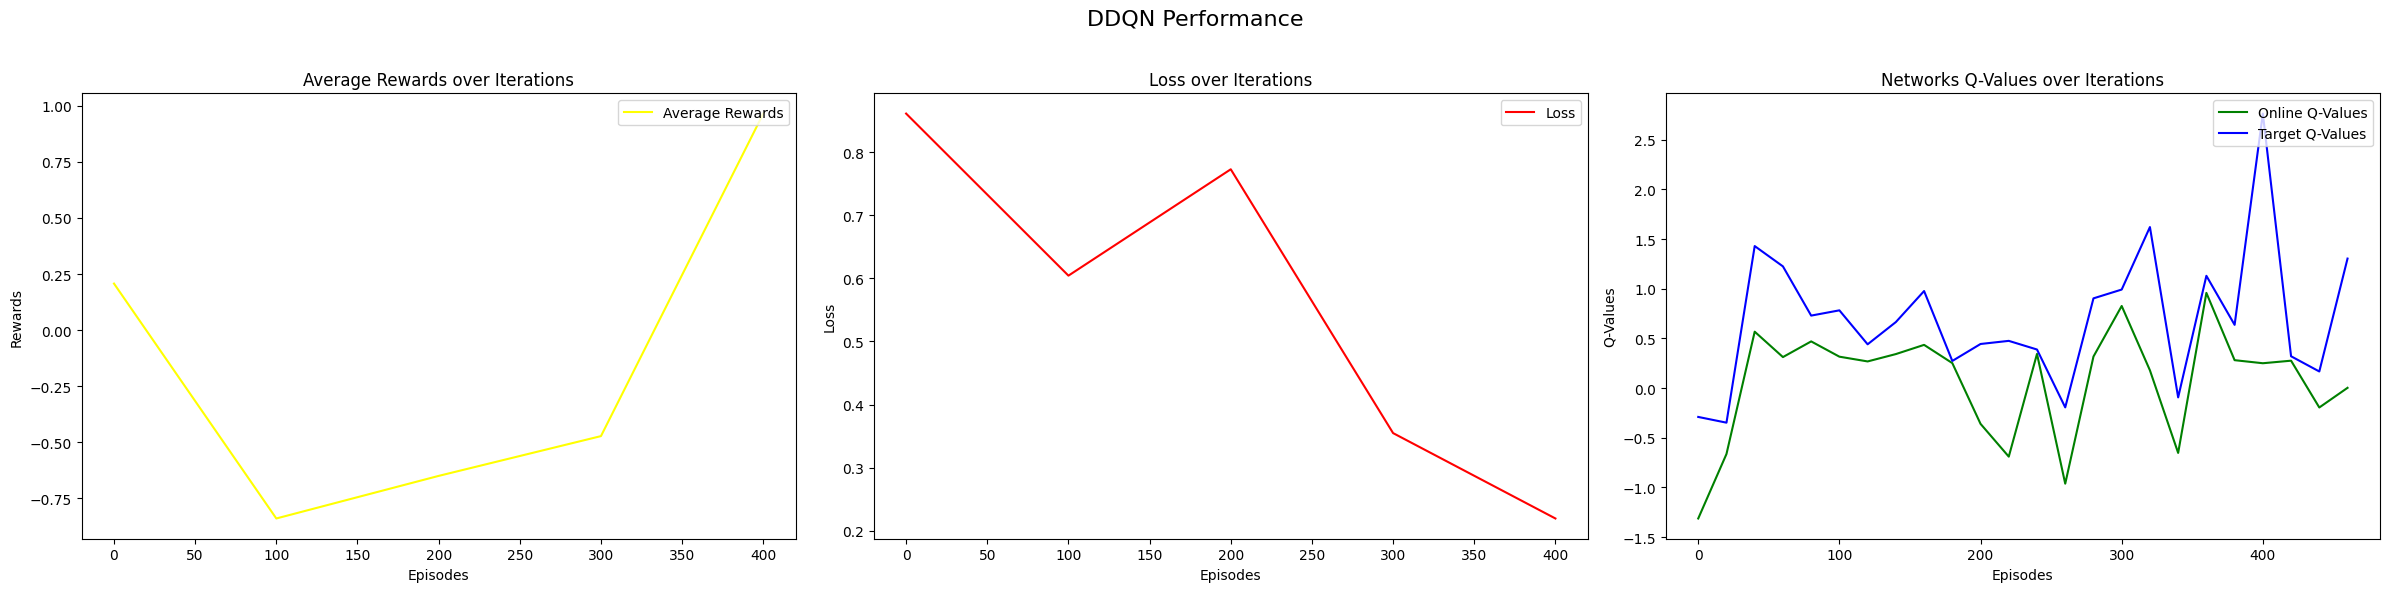

In [14]:
sim = TradingSimulator(
    env=train_env,
    eval_env=test_env,
    agent=agent,
    collect_steps=len(train_data)
)
rewards, losses, q_values, target_q_values = sim.train(strategy=strategy)

sim.plot_performance(rewards, losses, q_values, target_q_values)

In [15]:
policy, total_rewards, avg_return = sim.load_and_eval_policy(policy_path=MODELS_PATH)

Checkpoint restored: <tensorflow.python.checkpoint.checkpoint.InitializationOnlyStatus object at 0x7ca559fe5c90>
Average Return = 0.9435732364654541, Total Return = 444.4230041503906


In [16]:
def get_trade_metrics(df, risk_free_rate=RISK_FREE_RATE, market_index=None):
    """
    Calculate various performance metrics for the trading strategy based on the given trade data.

    Args:
        df (pd.DataFrame): DataFrame containing trading data with at least 'Returns' and 'Position' columns.
        risk_free_rate (float): Risk-free rate used for Sharpe and Sortino ratios.
        market_index (pd.DataFrame, optional): Market index DataFrame to calculate Beta, with a 'Close' column.

    Returns:
        pd.DataFrame: A DataFrame with calculated metrics including:
            - Cumulative Returns
            - Annualized Returns
            - Maximum Return
            - Maximum Loss
            - Variance
            - Standard Deviation
            - Maximum Drawdown
            - Drawdown Length
            - Sharpe Ratio
            - Sortino Ratio
            - Number of Trades
            - Trades per Interval
            - Number of Intervals
            - Returns Skewness
            - Returns Kurtosis
            - Beta
            - Information Ratio
            - Trade Churn
            - Profitability Ratio [%]
    """
    def calc_annualized_sharpe(rets, risk_free_rate=RISK_FREE_RATE):
        mean_rets = rets.mean()
        std_rets = rets.std()
        sharpe_ratio = 0.
        if std_rets != 0:
            sharpe_ratio = (mean_rets - (risk_free_rate / TRADING_DAYS_YEAR)) / std_rets
            sharpe_ratio *= np.sqrt(TRADING_DAYS_YEAR)
        return sharpe_ratio

    def calc_annualized_sortino(returns, risk_free_rate):
        downside_risk = np.sqrt(((returns[returns < 0])**2).mean()) * np.sqrt(TRADING_DAYS_YEAR)
        return (returns.mean() * TRADING_DAYS_YEAR - risk_free_rate) / downside_risk

    variance = df['Returns'].var()
    sharpe = calc_annualized_sharpe(df['Returns'],  risk_free_rate=risk_free_rate)
    sortino = calc_annualized_sortino(df['Returns'],  risk_free_rate=risk_free_rate)

    df['Drawdown'] = (1 + df['Returns']).cumprod().div((1 + df['Returns']).cumprod().cummax()) - 1
    max_drawdown = df['Drawdown'].min()
    drawdown_length = (df['Drawdown'] < 0).astype(int).groupby(df['Drawdown'].eq(0).cumsum()).cumsum().max()

    trades = (df['Position'].diff().ne(0) & df['Position'].ne(0)).sum()

    beta = None
    if market_index is not None:
        market_index['Returns'] = pd.to_numeric(market_index['Close'].pct_change().fillna(0), errors='coerce').fillna(0)
        y = pd.to_numeric(df['Returns'], errors='coerce').fillna(0)
        X = add_constant(market_index['Returns'].reset_index(drop=True))
        y = y.iloc[:len(X)].reset_index(drop=True)
        X = X.iloc[:len(y)].reset_index(drop=True)
        model = OLS(y, X).fit()
        beta = model.params[1]

    active_return = df['Returns'] - (risk_free_rate / TRADING_DAYS_YEAR)
    tracking_error = active_return.std()
    information_ratio = (active_return.mean() / tracking_error) * np.sqrt(TRADING_DAYS_YEAR)
    trade_churn = trades / len(df)
    cumulative_return = (np.cumprod(1 + df['Returns']) - 1).iloc[-1] if not df['Returns'].empty else 0
    annualized_return = (1 + cumulative_return)**(TRADING_DAYS_YEAR / len(df)) - 1 if len(df) > 0 else 0
    winning_trades = df[df['Returns'] > 0]['Returns']
    profitability_ratio = (winning_trades.sum() / len(df)) * 100

    stats_df = pd.DataFrame({
        "Cumulative Returns": [cumulative_return],
        "Annualized Returns": [annualized_return],
        "Maximum Return": [df['Returns'].max()],
        "Maximum Loss": [df['Returns'].min()],
        "Variance": [variance],
        "Standard Deviation": [np.sqrt(variance)],
        "Maximum Drawdown": [max_drawdown],
        "Drawdown Length": [drawdown_length],
        "Sharpe Ratio": [sharpe],
        "Sortino Ratio": [sortino],
        "Number of Trades": [trades],
        "Trades per Interval": [trades / len(df)],
        "Number of Intervals": [len(df)],
        "Returns": [df['Returns'].to_numpy()],
        "Returns Skewness": [skew(df['Returns'].to_numpy())],
        "Returns Kurtosis": [kurtosis(df['Returns'].to_numpy())],
        "Beta": [beta],
        "Information Ratio": [information_ratio],
        "Trade Churn": [trade_churn],
        "Profitability Ratio [%]": [profitability_ratio],
    })

    return stats_df

metrics = get_trade_metrics(test_env.get_trade_data(), market_index=tickers[MARKET])
metrics.drop(columns=["Returns"]).T

,0
Cumulative Returns,2.243776
Annualized Returns,0.805275
Maximum Return,0.176685
Maximum Loss,-0.137814
Variance,0.001070
Standard Deviation,0.032713
Maximum Drawdown,-0.222911
Drawdown Length,64.000000
Sharpe Ratio,1.353269
Sortino Ratio,1.468893


Cumulative Ret from the strategy: 224.38%


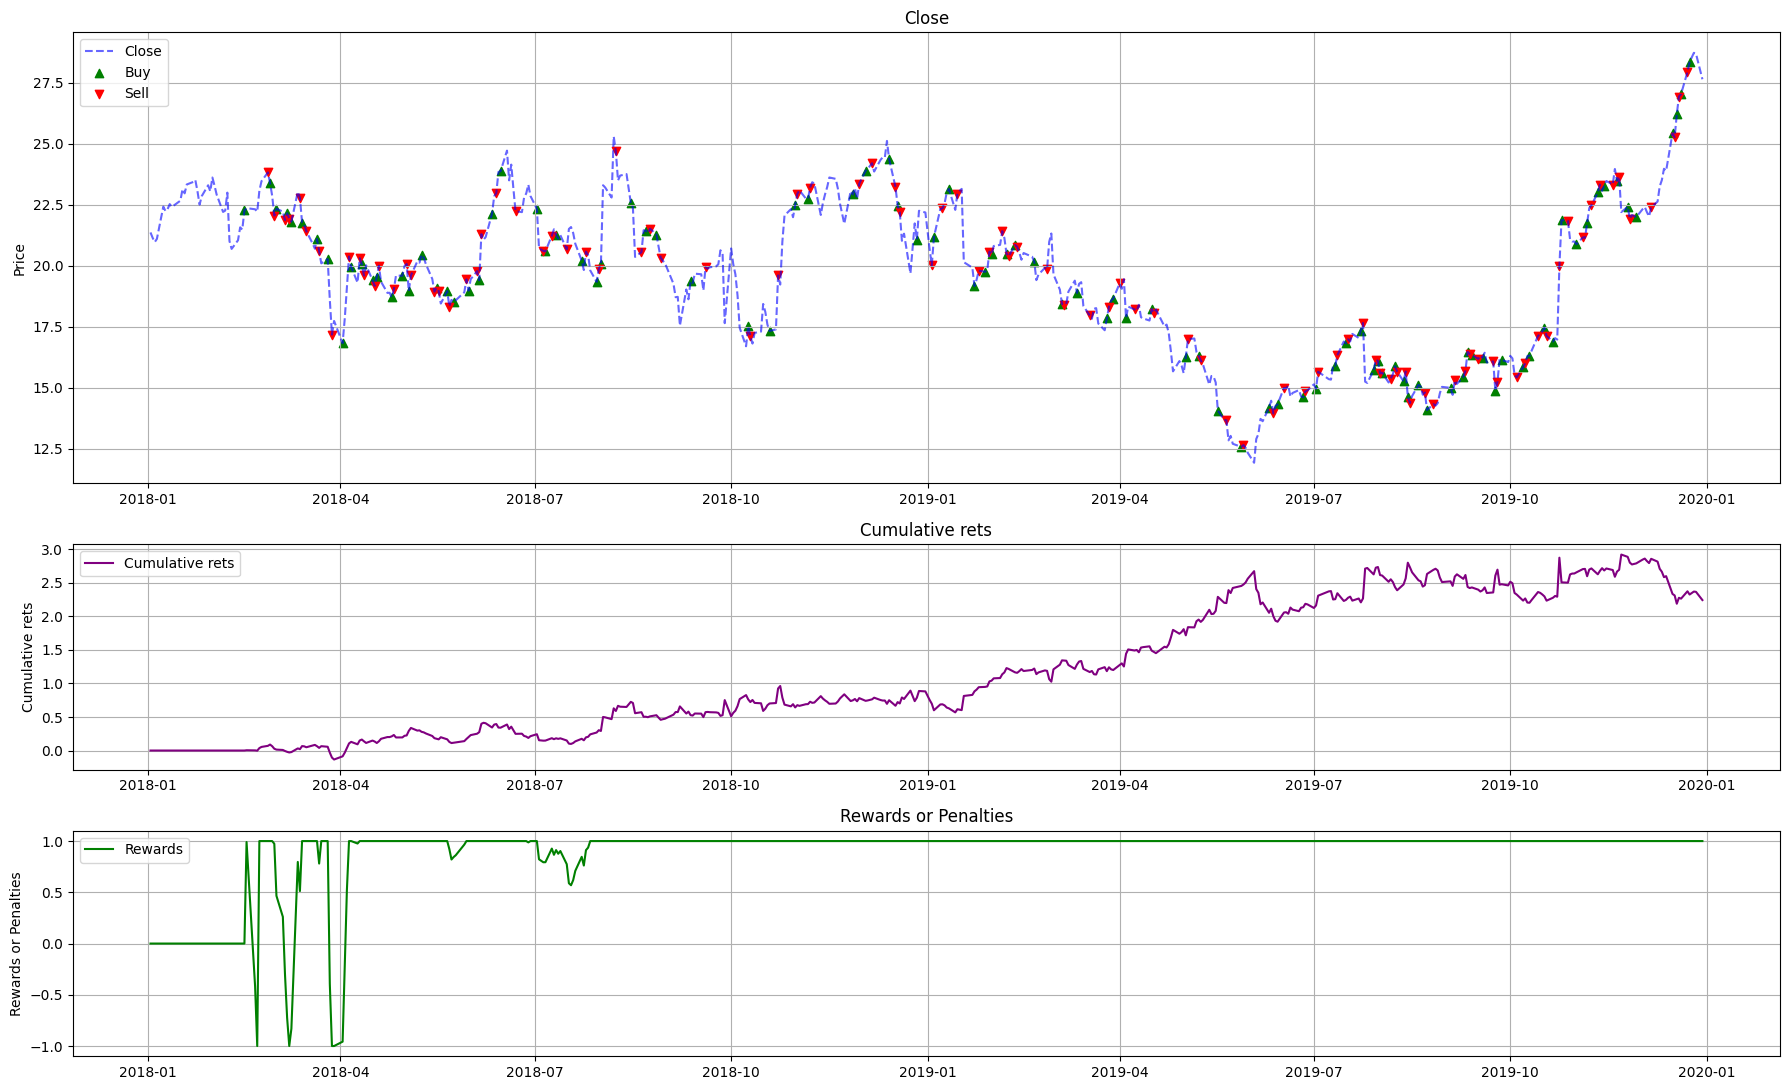

In [17]:
sim.plot_eval_trades()

## Manual Policy Inference

In [18]:
trade_data = test_env.get_trade_data()
trade_data.reset_index(inplace=True)
print(trade_data[trade_data['Action'].isin([ACT_LONG, ACT_SHORT])]['Action'].tail(5))

last_trade_step = trade_data[trade_data['Action'].isin([ACT_LONG, ACT_SHORT])].iloc[-1].name
start_idx = max(0, last_trade_step - test_env.state_length + 1)
end_idx = last_trade_step + 1

last_trade_state = trade_data.iloc[start_idx:end_idx][test_env.features].values.flatten().astype(np.float32)
batched_observation = np.expand_dims(last_trade_state, axis=0)
q_values, _ = agent._q_network(batched_observation)
print(q_values)

predicted_action = np.argmax(q_values, axis=1)[0]
print(f"Predicted Action: {predicted_action} => Returns: {trade_data.loc[last_trade_step, 'Returns']} and Rewards: {trade_data.loc[last_trade_step, 'Reward']}")

494    1
495    0
496    1
497    0
498    1
Name: Action, dtype: int64
tf.Tensor([[0.0939436  0.36415246]], shape=(1, 2), dtype=float32)
Predicted Action: 1 => Returns: -0.014383394140034837 and Rewards: 1.0


# Validation Runs

Given an RL algorithm is inherintly stochastic, we want to get an approximation with variance of its performance across all metrics.

In [19]:
def validate_agent(trading_simulator, test_env, strategy=None, num_runs=VALIDATION_ITERS, market_index=None):
    """
    Validate the RL algorithm by running training and evaluation multiple times, and calculating trade metrics.

    Parameters:
    - trading_simulator: Instance of the TradingSimulator class.
    - test_env: The environment used for evaluation after training.
    - strategy: TensorFlow strategy for distributed training, if applicable.
    - num_runs: Number of times to run the DDQN training and evaluation.
    - market_index: Market index data (e.g., S&P 500) to calculate beta and other metrics.

    Returns:
    - metrics_df: A DataFrame containing the mean and standard deviation of aggregated metrics and trading statistics.
    """
    all_eval_rewards, all_eval_returns, all_trade_metrics = [], [], []

    for run in tqdm(range(num_runs), desc="Validating Algo..."):
        trading_simulator.train(checkpoint_path=None,
                                strategy=strategy)
        total_returns, avg_rewards = trading_simulator.eval_metrics(strategy)
        all_eval_rewards.append(np.mean(avg_rewards))
        all_eval_returns.append(np.sum(total_returns))
        trade_data = test_env.get_trade_data()
        run_trade_metrics = get_trade_metrics(trade_data, market_index=market_index)
        all_trade_metrics.append(run_trade_metrics.drop(columns=["Returns"]).T)
    core_metrics_summary = pd.DataFrame({
        'Metric': ['Eval Rewards', 'Eval Total Return'],
        'Mean': [np.mean(all_eval_rewards), np.mean(all_eval_returns)],
        '-/+ Std': [np.std(all_eval_rewards), np.std(all_eval_returns)]
    })

    # Aggregate trading metrics across all runs
    trade_metrics_mean = pd.concat(all_trade_metrics, axis=1).mean(axis=1).to_frame('Mean')
    trade_metrics_std = pd.concat(all_trade_metrics, axis=1).std(axis=1).to_frame('-/+ Std')
    trade_metrics_summary = trade_metrics_mean.join(trade_metrics_std).reset_index().rename(columns={'index': 'Metric'})

    # Combine core metrics and trading metrics into final DataFrame
    combined_metrics = pd.concat([core_metrics_summary, trade_metrics_summary], ignore_index=True)

    return combined_metrics

In [20]:
val_trading_simulator = TradingSimulator(train_env,
                                     test_env,
                                     agent,
                                     collect_steps=len(train_data),
                                     log_interval=None,  # Silence these for validation.
                                     eval_interval=None, # We validate after the full training.
                                )
metrics_df = validate_agent(val_trading_simulator,
                            test_env,
                            num_runs=VALIDATION_ITERS,
                            strategy=strategy,
                            market_index=tickers[MARKET])
metrics_df

Validating Algo...:   0%|          | 0/10 [00:00<?, ?it/s][reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpbryrsj3j.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmpbryrsj3j
[reverb/cc/platform/default/server.cc:71] Started replay server on port 44757


Training from step: 0 to step: 500


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (23) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/platform/default/server.cc:84] Shutting down replay server
Validating Algo...:  10%|█         | 1/10 [18:11<2:43:40, 1091.13s/it][reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmp762bxya2.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmp762bxya2
[reverb/cc/platform/default/server.cc:71] Started replay server on port 33261


Training from step: 0 to step: 500


[reverb/cc/platform/default/server.cc:84] Shutting down replay server
Validating Algo...:  20%|██        | 2/10 [35:32<2:21:36, 1062.10s/it][reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmp5vfngfr1.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmp5vfngfr1
[reverb/cc/platform/default/server.cc:71] Started replay server on port 36857


Training from step: 0 to step: 500


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (23) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/platform/default/server.cc:84] Shutting down replay server
Validating Algo...:  30%|███       | 3/10 [52:43<2:02:14, 1047.86s/it][reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmp0j__8ttm.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmp0j__8ttm
[reverb/cc/platform/default/server.cc:71] Started replay server on port 38111


Training from step: 0 to step: 500


[reverb/cc/platform/default/server.cc:84] Shutting down replay server
Validating Algo...:  40%|████      | 4/10 [1:09:53<1:44:04, 1040.82s/it][reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpjw3hrqrr.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmpjw3hrqrr
[reverb/cc/platform/default/server.cc:71] Started replay server on port 41751


Training from step: 0 to step: 500


[reverb/cc/platform/default/server.cc:84] Shutting down replay server
Validating Algo...:  50%|█████     | 5/10 [1:26:52<1:26:03, 1032.71s/it][reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpd9j46lru.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmpd9j46lru
[reverb/cc/platform/default/server.cc:71] Started replay server on port 39965


Training from step: 0 to step: 500


[reverb/cc/platform/default/server.cc:84] Shutting down replay server
Validating Algo...:  60%|██████    | 6/10 [1:43:54<1:08:36, 1029.25s/it][reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmplfrta_a8.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmplfrta_a8
[reverb/cc/platform/default/server.cc:71] Started replay server on port 41827


Training from step: 0 to step: 500


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (23) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/platform/default/server.cc:84] Shutting down replay server
Validating Algo...:  70%|███████   | 7/10 [2:00:46<51:11, 1023.69s/it]  [reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpigqjeupt.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmpigqjeupt
[reverb/cc/platform/default/server.cc:71] Started replay server on port 46207


Training from step: 0 to step: 500


[reverb/cc/platform/default/server.cc:84] Shutting down replay server
Validating Algo...:  80%|████████  | 8/10 [2:17:39<34:00, 1020.16s/it][reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpey17rzwl.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmpey17rzwl
[reverb/cc/platform/default/server.cc:71] Started replay server on port 46835


Training from step: 0 to step: 500


[reverb/cc/platform/default/server.cc:84] Shutting down replay server
Validating Algo...:  90%|█████████ | 9/10 [2:34:39<17:00, 1020.09s/it][reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpvlvjlaf5.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmpvlvjlaf5
[reverb/cc/platform/default/server.cc:71] Started replay server on port 37171


Training from step: 0 to step: 500


[reverb/cc/platform/default/server.cc:84] Shutting down replay server
Validating Algo...: 100%|██████████| 10/10 [2:51:20<00:00, 1028.02s/it]


,Metric,Mean,-/+ Std
0,Eval Rewards,-0.048315,0.525051
1,Eval Total Return,-22.756512,247.299240
2,Cumulative Returns,-0.260277,0.580102
3,Annualized Returns,-0.187350,0.296468
4,Maximum Return,0.171076,0.020682
5,Maximum Loss,-0.164492,0.028753
6,Variance,0.001083,0.000189
7,Standard Deviation,0.032797,0.002899
8,Maximum Drawdown,-0.647151,0.123586
9,Drawdown Length,344.700000,114.491193
